In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
# from ilan_src.models import *
from src.dataloader import *
from src.utils import *
from src.evaluation import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

# Load test data

In [3]:
# ds_test_ens = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_log_trans_first_days_2.pkl", "rb"))

ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_log_trans_full.pkl", "rb"))
# ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_single_forecast_only_log_trans_first_days_2.pkl", "rb"))
# ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_single_forecast_only_log_trans_full_padded_24.pkl", "rb"))

# sampler_ens_test = torch.utils.data.SequentialSampler(ds_test_ens)
sampler_test = torch.utils.data.SequentialSampler(ds_test)
# sampler_test = torch.utils.data.WeightedRandomSampler(ds_test.compute_weights(), len(ds_test))

dl_test = torch.utils.data.DataLoader(
    ds_test, batch_size=64, sampler=sampler_test
)

# dl_test_ens = torch.utils.data.DataLoader(
#     ds_test_ens, batch_size=64, sampler=sampler_ens_test
# )

# Load model

In [4]:
# gan = LeinGANGP.load_from_checkpoint("/home/jupyter/data/saved_models/leingan/epoch=120-step=324279.ckpt")

# gan = WGANGP.load_from_checkpoint("/home/jupyter/data/saved_models/wgan-gp-smoothed/epoch=123-step=332319.ckpt")

gan = BaseGAN.load_from_checkpoint("/home/jupyter/data/saved_models/epoch=149-step=100499.ckpt")

gen = gan.gen
gen = gen.to(device)
gen.train(False);

### Sanity check plots

In [5]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3]).to(device)
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        if lr.shape[0]==64:
            lr = lr[24:40, 24:40]
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

(64, 1, 128, 128)
(64, 1, 128, 128)
(64, 1, 128, 128)
(64, 1, 128, 128)


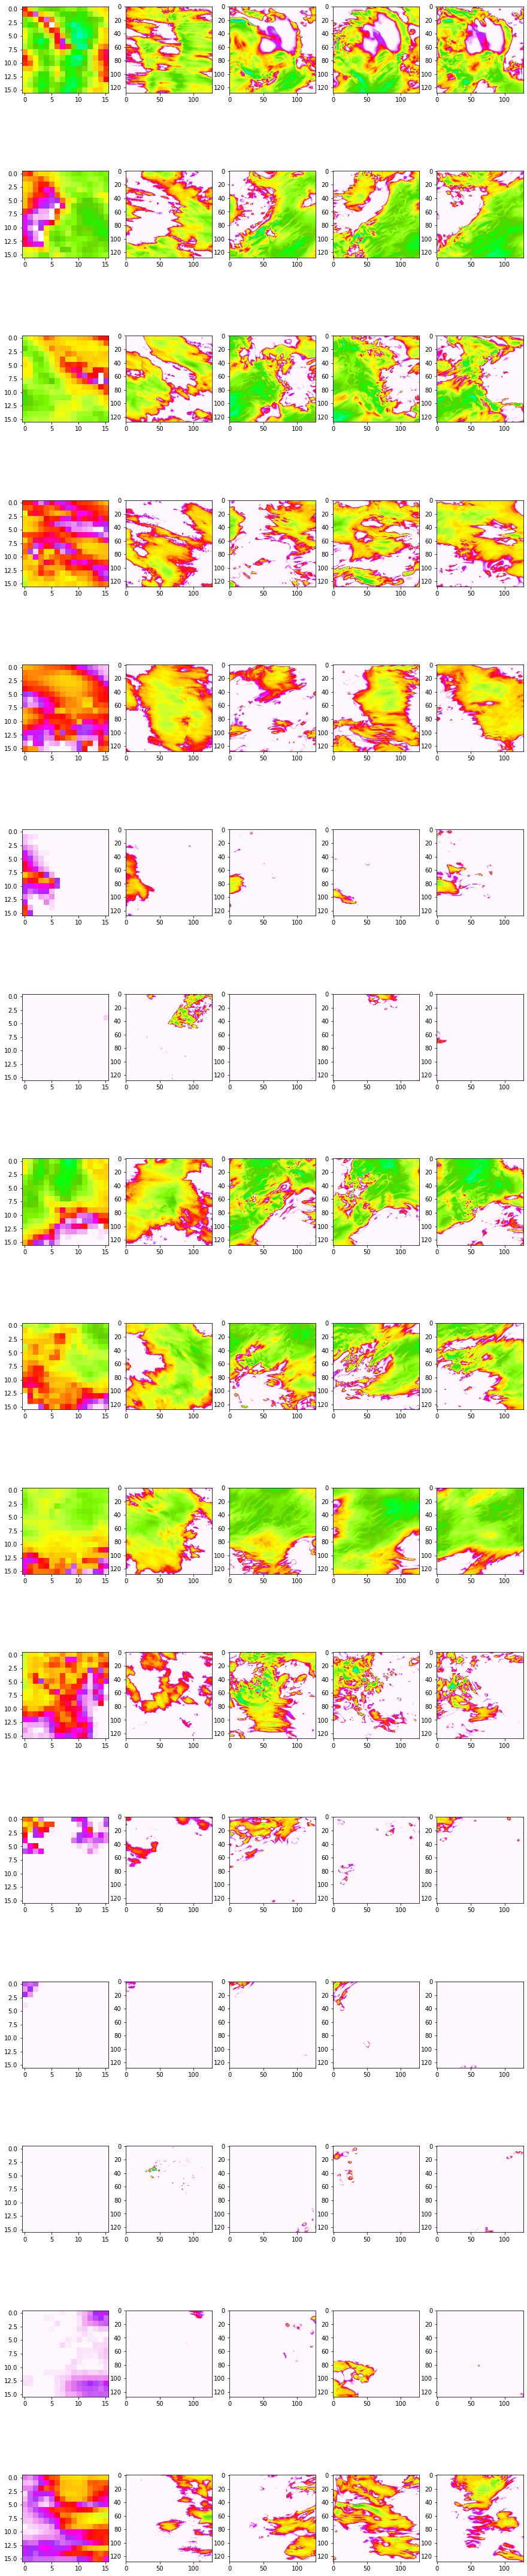

In [6]:
x_sample, y_sample = next(iter(dl_test))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
plot_samples_per_input(x_sample, y_sample, gen, k=16)

# Eval Model

## Evaluation

In [7]:
num_samples = 30

### By Patch

In [ ]:
patch_crps, patch_rmse = gen_patch_eval(gen, dl_test, num_samples, ds_test.mins.tp.values, ds_test.maxs.tp.values, ds_test.tp_log, device)

In [ ]:
print(patch_crps)

In [ ]:
print(patch_rmse)

### By full map

In [21]:
# get full map ground truth
mrms = get_full_masked_mrms(gen, ds_test, device)

preds, full_crps, full_rmse = gen_full_eval(gen, ds_test, mrms, num_samples, device)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [22]:
print(full_crps)

0.33325303342811236


In [23]:
print(full_rmse)

1.9299071032426056


In [24]:
mrms_pert = mrms + np.random.normal(scale=1e-6, size=mrms.shape)

preds_pert = preds + np.random.normal(scale=1e-6, size = preds.shape)

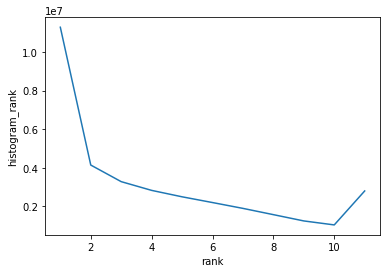

In [26]:
xs.rank_histogram(mrms_pert.chunk({'valid_time': 1}), preds_pert.chunk({'valid_time': 1})).compute().plot()

## Interpolation baseline

In [13]:
# rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
# eval_mask = rq>-1
# fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
# ds = xr.open_dataset(fn)
# assert eval_mask.lat.shape ==ds.lat.shape
# eval_mask['lat'] = ds.lat 
# assert eval_mask.lon.shape ==ds.lon.shape
# eval_mask['lon'] = ds.lon

# mrms_ens = ds_test_ens.mrms.rename(
#     {'time': 'valid_time'})
# mrms_ens = mrms_ens.where(eval_mask)

# tigge, interp, interp_rmse = interpolation_full_baseline(ds_test_ens, mrms_ens)

tigge, interp, interp_rmse = interpolation_full_baseline(ds_test, mrms)

In [14]:
print(interp_rmse)

[1.91968383 2.02185535 2.01350497 2.02008192 1.94957799 1.9719688
 1.94239027 1.85786179 1.90849807 1.97317626]


In [15]:
interp_pert = interp + np.random.normal(scale=1e-6, size=interp.shape)

In [17]:
mrms_ens_pert = mrms_ens + np.random.normal(scale=1e-6, size=mrms_ens.shape)

In [16]:
interp_pert

<xarray.DataArray (member: 10, valid_time: 44, lat: 750, lon: 1376)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
  * member      (member) int32 0 1 2 3 4 5 6 7 8 9
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

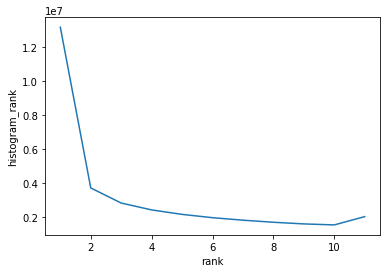

In [18]:
xs.rank_histogram(mrms_ens_pert.chunk({'valid_time': 1}), interp_pert.chunk({'valid_time': 1})).compute().plot()

# Visulising full map

In [16]:
eval_mask = make_eval_mask()

In [20]:
valid_time = 10

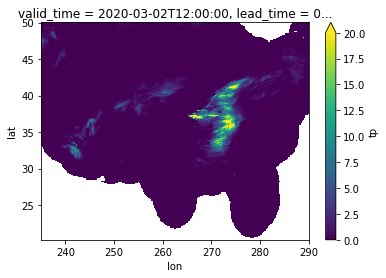

In [21]:
mrms.isel(valid_time=valid_time).plot(vmin=0, vmax=20)

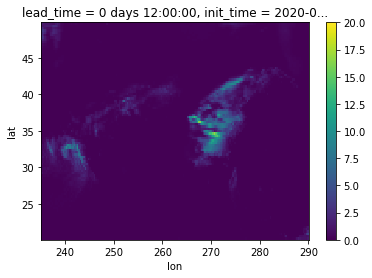

In [25]:
tigge.isel(valid_time=valid_time).plot(vmin=0, vmax=20)

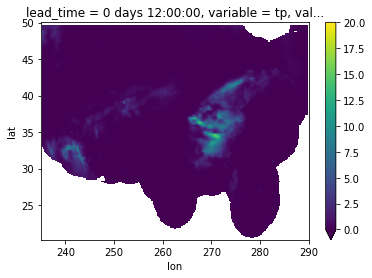

In [27]:
interp.where(eval_mask).isel(valid_time=valid_time).plot(vmin=0, vmax=20)

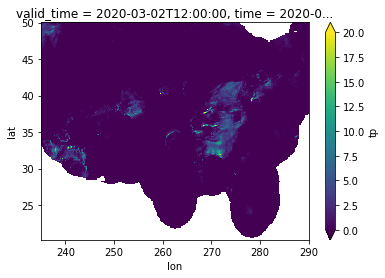

In [28]:
for i in range(1):
    plt.figure()
    preds.where(eval_mask).isel(valid_time = valid_time, member=i).plot(vmin=0, vmax=20)